In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from pathlib import Path
from statannotations.Annotator import Annotator
from petTOAD_setup import *
from petTOAD_group_level_analysis import n_simulations, load_df_arrays

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


In [2]:
SIM_DIR = RES_DIR / "final_simulations_log_2023-11-23"
SIM_GROUP_DIR = RES_DIR / "final_simulations"
A_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0"
A_RAND_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0_random"
G_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0"
G_RAND_DIR = SIM_DIR / "G-weight_ws_-1.o-0.0_bs_-0.5-0.0_random"
SC_DIR = SIM_DIR / "sc_disconn_ws_-0.5-0.0_bs_0"
SC_RAND_DIR = SIM_DIR / "sc_disconn_ws_-0.5-0.0_bs_0_random"
HET_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0"
HET_RAND_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0_random"

In [3]:
def _get_share_ax(share_var, axarr, row, col):
    "From: https://wil.yegelwel.com/subplots-with-row-titles/"
    if share_var == "row":
        if col > 0:
            return axarr[row, col - 1]
        return None
    elif share_var == "col":
        if row > 0:
            return axarr[row - 1, col]
        return None
    elif share_var and (col > 0 or row > 0):
        return axarr[0, 0]
    return None


def subplots_with_row_titles(
    nrows,
    ncols,
    row_titles=None,
    row_title_kw=None,
    sharex=False,
    sharey=False,
    subplot_kw=None,
    grid_spec_kw=None,
    **fig_kw,
):
    """
    Creates a figure and array of axes with a title for each row.
    From: https://wil.yegelwel.com/subplots-with-row-titles/
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(
            f"If row_titles is specified, there must be one for each row. Got={row_titles}"
        )
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, "row", "col"}:
        raise ValueError(
            f'sharex must be one of [True, False, "row", "col"]. Got={sharex}'
        )
    if sharey not in {True, False, "row", "col"}:
        raise ValueError(
            f'sharey must be one of [True, False, "row", "col"]. Got={sharey}'
        )

    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for row, big_ax in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.tick_params(
            labelcolor=(1.0, 1.0, 1.0, 0.0),
            top="off",
            bottom="off",
            left="off",
            right="off",
        )
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax._frameon = False

    axarr = np.empty((nrows, ncols), dtype="O")
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)

            ax = fig.add_subplot(
                nrows,
                ncols,
                row * ncols + col + 1,
                sharex=sharex_ax,
                sharey=sharey_ax,
                **subplot_kw,
            )
            axarr[row, col] = ax
    return fig, axarr


def save_annotator_results_raw(
    groupname: str,
    data_type: str,
    model_type: str,
    results: Annotator.apply_and_annotate,
    comparing_what: str,
):
    """
    Save annotator results in raw format to a CSV file.

    Parameters:
    - groupname (str): The name of the group or "all" for all groups.
    - data_type (str): The type of data being compared (simulated or empirical).
    - model_type (str): The type of model used for comparison.
    - results (list): List of results objects containing data for each comparison from statannotations.Annotator.apply_and_annotate()
    - comparing_what (str): The aspect of comparison (e.g., integration, segregation).

    Returns:
    None

    This function takes in the specified parameters and extracts relevant information
    from the results to create a DataFrame. It then saves this DataFrame to a CSV file.
    The CSV file is named based on the provided parameters and is stored in the SIM_GROUP_DIR
    directory.

    Example Usage:
    save_annotator_results_raw("MCI_WMH", "simulated", "homogeneous_G", results, "integration")
    """

    dict_res = {}
    for res in results:
        dict_key = res.data.group1 + "_" + res.data.group2
        dict_res[dict_key] = res.data.formatted_output.split(",")[1]
    test_name = res.data.formatted_output.split(",")[0]
    df = pd.DataFrame(dict_res, index=[test_name]).T
    if groupname == "all":
        df.to_csv(
            SIM_GROUP_DIR
            / f"group-{groupname}_data-{data_type}_model-{model_type}_desc-df-{comparing_what}-comparison.csv"
        )
    else:
        df.to_csv(
            SIM_GROUP_DIR
            / groupname
            / f"group-{groupname}_data-{data_type}_model-{model_type}_desc-df-{comparing_what}-comparison.csv"
        )

def write_figure_letters(axs):
    import string
    axs = axs.flat
    for n, ax in enumerate(axs):
        ax.text(
            -0.1,
            1.1,
            string.ascii_uppercase[n],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

In [4]:
# General linear regression functions
def lin_reg(df_int_seg, x, y):
    X = sm.add_constant(df_int_seg[x])
    Y = df_int_seg[y]
    # Fit the model
    model = sm.OLS(Y, X).fit()
    return model.params[x], model.params['const'], model.pvalues[x]

def lin_reg_parm(df, group, x, y):
    X = pd.to_numeric(df[x])
    Y = pd.to_numeric(df[y])
    # Use statsmodels to calculate p-values for the coefficients
    X_with_intercept = sm.add_constant(
        X
    )  # Add a constant (intercept) term to the features
    model = sm.OLS(
        Y, X_with_intercept
    ).fit()  # Fit an OLS (ordinary least squares) model
    # Get the coefficients (w) and intercept (b)
    lr_slope = model.params[x]
    lr_int = model.params["const"]
    r2 = model.rsquared
    p_slope = model.pvalues[x]

    return group, lr_slope, lr_int, r2, p_slope

# Plot linear regression
def regplot_with_corrcoef(group, df, x, y, ax, color=None):
    import scipy.stats as ss
    if group != "All":
        df = df[df["Group_bin_Fazekas"] == group].copy()
    dict_names = {"wmh_load": "WMH log",
                  "WMH_load_subj_space": "WMH (mm^3)",
                  "emp_int": "Empirical integration",
                  "sim_int": "Simulated integration",
                  "emp_seg": "Empirical segregation",
                  "sim_seg": "Simulated segregation",
                  "MMSE": "MMSE",
                  "PTEDUCAT": "Education (yrs)",
                  "Age": "Age",
                  }
    if group == "All":
        sns.regplot(data=df, x=x, y=y, ax=ax, color = color)
        groupname = group
    else:
        groupname = f"{group.split('_')[0]} {group.split('_')[1]}"
        sns.regplot(
            data=df[df["Group_bin_Fazekas"] == group],
            x=x,
            y=y,
            ax=ax,
            color=color,
        )
    r, p = ss.pearsonr(df[x], df[y])
    # Formatting the text for Spearman correlation and p-value
    text_str = f"Pearson r={r:.2f}, p={p:.3f}"

    ax.set_ylabel(f"{dict_names[y]}")
    ax.set_xlabel(f"{dict_names[x]}")    
    # Setting the text in the upper part of the graph
    ax.text(0.05, 0.98, text_str, transform=ax.transAxes, fontsize=9, verticalalignment='top')



# Plotting functions
def plot_sim_int_seg_subj_level(df_int_seg, axs, nrow, group):
    nrow_str = str(nrow)
    colors = {"0": "tab:orange",
              "1": "tab:blue",
              "2": "tab:green",}
    axs_row = axs[nrow, :]
    sns.regplot(data = df_int_seg, x = "sim_int", y = "emp_int", ax = axs_row[2], color = colors[nrow_str])
    sns.regplot(data = df_int_seg, x = "sim_seg", y = "emp_seg", ax = axs_row[3], label = group, color = colors[nrow_str])
    x_int, const_int, pval_int = lin_reg(df_int_seg, x = "sim_int", y = "emp_int")
    x_seg, const_seg, pval_seg = lin_reg(df_int_seg, x = "sim_seg", y = "emp_seg")
    title_int = f"y = {x_int:.2f}*sim_int + {const_int:.2f}, pval = {pval_int:.3f}"
    title_seg = f"y = {x_seg:.2f}*sim_seg + {const_seg:.2f}, pval = {pval_seg:.3f}"
    axs_row[2].set_title(title_int)
    axs_row[3].set_title(title_seg)
    axs_row[2].set_xlabel("Simulated integration")
    axs_row[2].set_ylabel("Empirical integration")
    axs_row[3].set_xlabel("Simulated segregation")
    axs_row[3].set_ylabel("Empirical segregation")
    axs_row[3].legend()

def plot_int_or_seg(df: pd.DataFrame, obs: str, model_type: str, ax: plt.Axes):
    """
    Plot boxplots for integration or segregation measures with statistical comparisons among Fazekas groups

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data for plotting.
    - obs (str): Name of the observation variable (e.g., "Integration" or "Segregation").
    - ax (plt.Axes): Matplotlib Axes object to draw the plot onto.

    Returns:
    - None
    """
    dict_axes = {"emp_int": "Empirical integration",
                 "emp_seg": "Empirical segregation"}
    order = ["CN_no_WMH", "CN_WMH", "MCI_no_WMH", "MCI_WMH"]
    # Choose the combinations that you want to test..
    pairs = [
        ("CN_no_WMH", "CN_WMH"),
        ("MCI_no_WMH", "MCI_WMH"),
    ]
    f = sns.boxplot(data=df, x="Group_bin_Fazekas", y=obs, ax=ax, order=order)
    annotator = Annotator(f, pairs, data=df, x="Group_bin_Fazekas", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(
        test="Mann-Whitney", text_format="star", loc="inside", verbose=1
    )
    _, results = annotator.apply_and_annotate()
    ax.set_xticks([0, 1, 2, 3], order)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["CU no WMH", "CU WMH", "MCI no WMH", "MCI WMH"])
    ax.set_xlabel("Group")
    ax.set_ylabel(dict_axes[obs])


def plot_group_compare_emp_int_seg(df):
    fig, axs = plt.subplots(nrows=1, ncols = 2, figsize = (10, 5))
    plot_int_or_seg(df, "emp_int", "empirical", axs[0])
    plot_int_or_seg(df, "emp_seg", "empirical", axs[1])
    fig.tight_layout()
    #fig.savefig(FIG_DIR / f"group-all-single-subjects_data-empirical_model-None_desc-emp-int-seg-group-comparison.png")


In [5]:
def load_df_sim_int_seg_for_plotting(model_type: str, n_rep: int):
    """
    Load DataFrames for integration and segregation for plotting.

    Parameters:
    - model_type (str): The type of model for which data is loaded ("homogeneous_a", "homogeneous_G") 
    - n_rep (int): The number of Monte Carlo repeats.

    Returns:
    - df_int_sim_box (DataFrame): DataFrame containing integration simulation data for plotting in long format for all the models.
    - df_seg_sim_box (DataFrame): DataFrame containing segregation simulation data for plotting in long format for all the models.

    This function reads CSV files containing integration and segregation simulation data for specified model types
    and the given number of Monte Carlo repeats. It filters the data for relevant baseline and WMH models and returns
    DataFrames ready for plotting boxplots.

    Example Usage:
    df_integration, df_segregation = load_df_sim_int_seg_for_plotting("homogeneous_a", 100)
    """
    df_int_sim_long = pd.read_csv(
        SIM_GROUP_DIR
        / f"group-all_data-simulated_model-all_desc-df-integration-montecarlo-{n_rep}-repeats.csv",
        index_col=0,
    )  
    df_seg_sim_long = pd.read_csv(
        SIM_GROUP_DIR
        / f"group-all_data-simulated_model-all_desc-df-segregation-montecarlo-{n_rep}-repeats.csv",
        index_col=0,
    )  
    baseline_models = ["CN_no_WMH_homogeneous_G", "MCI_no_WMH_homogeneous_a"]

    if model_type == "homogeneous_a":
        wmh_models = ["CN_WMH_homogeneous_a", "MCI_WMH_homogeneous_a"]
    elif model_type == "homogeneous_G":
        wmh_models = ["CN_WMH_homogeneous_G", "MCI_WMH_homogeneous_G"]

    df_int_sim_box = df_int_sim_long[
        df_int_sim_long["group_model"].isin(baseline_models + wmh_models)
    ]
    df_seg_sim_box = df_seg_sim_long[
        df_seg_sim_long["group_model"].isin(baseline_models + wmh_models)
    ]
    return df_int_sim_box, df_seg_sim_box

def load_df_sim_int_seg_ss_for_plotting(model_type, n_rep):
    df_int = pd.read_csv(SIM_DIR / f"group-all-sing-subj_data-simulated_model-{model_type}_desc-df-int-montecarlo-{n_rep}-repeats.csv", index_col = 0)
    df_seg = pd.read_csv(SIM_DIR / f"group-all-sing-subj_data-simulated_model-{model_type}_desc-df-seg-montecarlo-{n_rep}-repeats.csv", index_col = 0)
    return df_int, df_seg 


def load_df_integration_segregation(n_sim: int):
    df_int_emp = pd.read_csv(
        SIM_GROUP_DIR
        / f"group-all_data-empirical_desc-df-integration-montecarlo-{n_sim}-repeats.csv",
        index_col=0,
    )
    df_seg_emp = pd.read_csv(
        SIM_GROUP_DIR
        / f"group-all_data-empirical_desc-df-segregation-montecarlo-{n_sim}-repeats.csv",
        index_col=0,
    )

    df_int_a, df_seg_a = load_df_sim_int_seg_for_plotting("homogeneous_a", n_rep=n_sim)
    df_int_G, df_seg_G = load_df_sim_int_seg_for_plotting("homogeneous_G", n_rep=n_sim)
    df_int_ss_G, df_seg_ss_G = load_df_sim_int_seg_ss_for_plotting("homogeneous_G", n_rep=n_sim)
    df_int_ss_sc_disconn, df_seg_ss_sc_disconn = load_df_sim_int_seg_ss_for_plotting("disconnectivity", n_rep=n_sim)
    
    return df_int_emp, df_seg_emp, df_int_a, df_seg_a, df_int_G, df_seg_G, df_int_ss_G, df_seg_ss_G, df_int_ss_sc_disconn, df_seg_ss_sc_disconn

def plot_int_or_seg(df: pd.DataFrame, obs: str, model_type: str, ax: plt.Axes):
    """
    Plot boxplots for integration or segregation measures with statistical comparisons among Fazekas groups

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data for plotting.
    - obs (str): Name of the observation variable (e.g., "Integration" or "Segregation").
    - ax (plt.Axes): Matplotlib Axes object to draw the plot onto.

    Returns:
    - None
    """
    order = ["CN_no_WMH", "CN_WMH", "MCI_no_WMH", "MCI_WMH"]
    # Choose the combinations that you want to test..
    pairs = [
        ("CN_no_WMH", "CN_WMH"),
        ("MCI_no_WMH", "MCI_WMH"),
    ]
    f = sns.boxplot(data=df, x="group", y=obs, ax=ax, order=order)
    annotator = Annotator(f, pairs, data=df, x="group", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(
        test="Mann-Whitney", text_format="star", loc="inside", verbose=1
    )
    _, results = annotator.apply_and_annotate()
    ax.set_xticks([0, 1, 2, 3], order)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["CU no WMH", "CU WMH", "MCI no WMH", "MCI WMH"])
    obs = obs.lower()
    #save_annotator_results_raw("all", "simulated", model_type, results, obs)


def plot_int_seg_comparison(
    df_int: pd.DataFrame,
    df_seg: pd.DataFrame,
    model: str,
    ax_int: plt.Axes,
    ax_seg: plt.Axes,
):
    """
    Plot side-by-side boxplots for integration and segregation measures.

    Parameters:
    - df_int (pd.DataFrame): DataFrame containing integration data.
    - df_seg (pd.DataFrame): DataFrame containing segregation data.

    Returns:
    - None
    """
    plot_int_or_seg(df_int, "Integration", model, ax_int)
    plot_int_or_seg(df_seg, "Segregation", model, ax_seg)

def plot_all_int_seg_comparisons(
    df_int_emp: pd.DataFrame,
    # df_int_a: pd.DataFrame,
    df_int_G: pd.DataFrame,
    df_int_ss_G: pd.DataFrame,
    df_int_ss_sc_disconn: pd.DataFrame,
    df_seg_emp: pd.DataFrame,
    # df_seg_a: pd.DataFrame,
    df_seg_G: pd.DataFrame,
    df_seg_ss_G: pd.DataFrame,
    df_seg_ss_sc_disconn: pd.DataFrame,    
):
    row_to_fn = ["Empirical", "Group Homog. G Model", "Single-subj. Homog. G model", "Single-subj. Disconn. model"] 
    fig, axs = subplots_with_row_titles(
        nrows=4, #4 
        ncols=2,
        figsize=(10, 18),
        row_titles=[f for f in row_to_fn],
        row_title_kw=dict(fontsize=12, pad=40, fontweight="bold"),
        sharex=False,
    )
    plot_int_seg_comparison(df_int_emp, df_seg_emp, "empirical", axs[0, 0], axs[0, 1])
    # plot_int_seg_comparison(df_int_a, df_seg_a, "homogeneous_a", axs[1, 0], axs[1, 1])
    plot_int_seg_comparison(df_int_G, df_seg_G, "homogeneous_G", axs[1, 0], axs[1, 1])
    plot_int_seg_comparison(df_int_ss_G, df_seg_ss_G, "ss_homogeneous_G", axs[2, 0], axs[2, 1])
    plot_int_seg_comparison(df_int_ss_sc_disconn, df_seg_ss_sc_disconn, "ss_disconnectivity", axs[3, 0], axs[3, 1])
    #write_figure_letters(axs)
    fig.tight_layout()
    # fig.savefig(
    #     FIG_DIR
    #     / "group-all_data-emp-sim_model-all_desc-boxplots-comparing-integration-segregation-no_wmh-vs-wmh.png"
    # )

def process_dfs_int_seg_for_plotting(df_emp, df_G, df_ss_G, df_ss_disconn, int_or_seg):

    # Define a mapping dictionary
    mapping = {
        'CN_no_WMH': 'CU no WMH',
        'CN_WMH': 'CU WMH',
        'MCI_no_WMH': 'MCI no WMH',
        'MCI_WMH': 'MCI WMH'
    }

    df_emp["type"] = "Empirical"
    df_G["type"] = "Group Homog. G"
    df_ss_G["type"] = "Single-subj. Homog. G"
    df_ss_disconn["type"] = "Single-subj. Disconn."

    groups = [df_emp, df_G, df_ss_G, df_ss_disconn]
    # Perform min-max scaling for each group separately
    scaled_dfs = []
    for group in groups:
        min_value = group[int_or_seg].min()
        max_value = group[int_or_seg].max()
        group['scaled_values'] = (group[int_or_seg] - min_value) / (max_value - min_value)
        scaled_dfs.append(group)
    
    df = pd.concat(scaled_dfs)
    # Use the map function to create the 'group_label' column
    df['group_label'] = df['group'].map(mapping)
    df = df.drop(columns= ["group_model", "model_type"])
    return df

def plot_int_seg_comparisons_models(df, y, ax):
    pairs = [
        [('Empirical', 'CU no WMH'), ('Empirical', 'CU WMH')],
        [('Empirical', 'MCI no WMH'), ('Empirical', 'MCI WMH')],
        [('Group Homog. G', 'CU no WMH'), ('Group Homog. G', 'CU WMH')],
        [('Group Homog. G', 'MCI no WMH'), ('Group Homog. G', 'MCI WMH')],
        [('Single-subj. Homog. G', 'CU no WMH'), ('Single-subj. Homog. G', 'CU WMH')],
        [('Single-subj. Homog. G', 'MCI no WMH'), ('Single-subj. Homog. G', 'MCI WMH')],
        [('Single-subj. Disconn.', 'CU no WMH'), ('Single-subj. Disconn.', 'CU WMH')],
        [('Single-subj. Disconn.', 'MCI no WMH'), ('Single-subj. Disconn.', 'MCI WMH')],
        
    ]

    hue_plot_params = {
        'data': df,
        'x': 'type',
        'y': y,
        "hue": "group_label",
    }


    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)
    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney").apply_and_annotate()

def plot_int_seg_final(df_int, df_seg):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (10, 12))
    plot_int_seg_comparisons_models(df_int, "Integration", axs[0])
    plot_int_seg_comparisons_models(df_seg, "scaled_values", axs[1])
    write_figure_letters(axs)
    axs[0].legend(title = "Group")
    axs[1].set_ylabel("Segregation")
    axs[1].legend().remove()
    fig.tight_layout()


def plot_int_or_seg_single_subject(df, y, ax):
    # Define a mapping dictionary
    mapping = {
        'CN_no_WMH': 'CU no WMH',
        'CN_WMH': 'CU WMH',
        'MCI_no_WMH': 'MCI no WMH',
        'MCI_WMH': 'MCI WMH',
        "emp_int": "Integration",
        "emp_seg": "Segregation"
    }

    df['group_label'] = df['Group_bin_Fazekas'].map(mapping)
    order = ["CU no WMH", "CU WMH", "MCI no WMH", "MCI WMH"]

    sns.boxplot(data = df, x = "group_label", y = y, ax = ax, order = order)
    pairs=[("CU no WMH", "CU WMH"), ("MCI no WMH", "MCI WMH")]
    annotator = Annotator(ax, pairs, data=df, x= "group_label", y=y, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    ax.set_xlabel("Group")
    ax.set_ylabel(mapping[y])

In [6]:
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Single-subj. Homog. G_MCI no WMH vs. Single-subj. Homog. G_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=9.904e+05
Single-subj. Disconn._CU no WMH vs. Single-subj. Disconn._CU WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.678e-194 U_stat=8.841e+05
Single-subj. Disconn._MCI no WMH vs. Single-subj. Disconn._MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.658e-233 U_stat=9.210e+05
Group Homog. G_MCI no WMH vs. Group Homog. G_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=9.932e+05
Single-subj. Homog. G_CU no WMH vs. Single-subj. Homog. G_CU WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=9.984e+05
Empirical_MCI no WMH vs. Empirical_MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.210e-292 U_stat=9.718e+05
Empirical_CU 

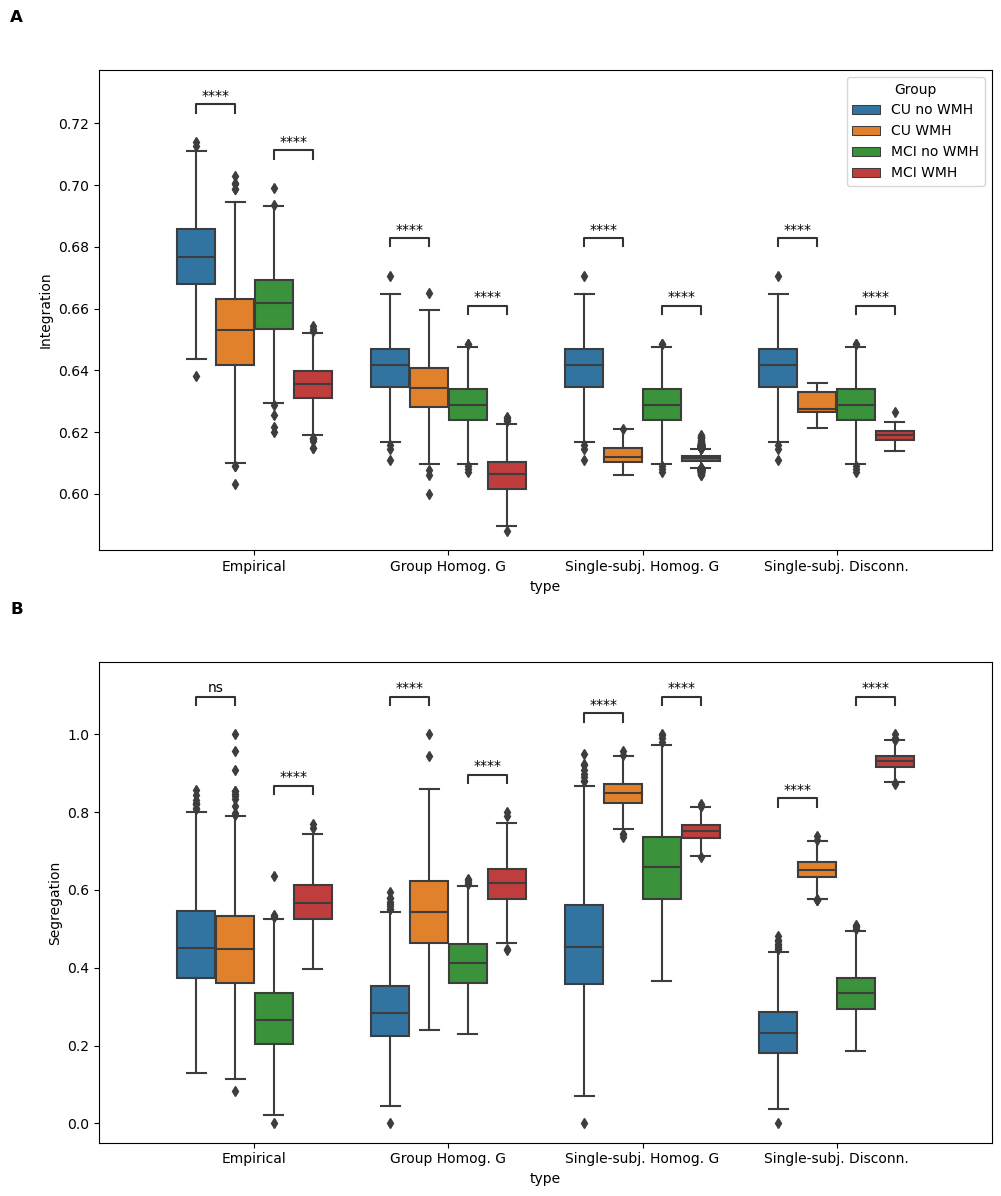

In [7]:
df_integration_emp, df_segregation_emp, df_integration_a, df_segregation_a, df_integration_G, df_segregation_G, df_int_ss_G, df_seg_ss_G, df_int_ss_disconn, df_seg_ss_disconn = load_df_integration_segregation(n_sim=n_simulations)
df_int_ss_G.rename(columns={"Group": "group"}, inplace = True)
df_seg_ss_G.rename(columns={"Group": "group"}, inplace = True)

df_int_ss_G["model_type"] = "single-subject-homogeneous_G"
df_seg_ss_G["model_type"] = "single-subject-homogeneous_G"
df_int_ss_disconn["model_type"] = "single-subject-disconnectivity"
df_seg_ss_disconn["model_type"] = "single-subject-disconnectivity"

df_int_ss_G = pd.concat([df_int_ss_G, df_integration_G[(df_integration_G["group"] == "CN_no_WMH") | (df_integration_G["group"] == "MCI_no_WMH")]])
df_seg_ss_G = pd.concat([df_seg_ss_G, df_segregation_G[(df_segregation_G["group"] == "CN_no_WMH") | (df_segregation_G["group"] == "MCI_no_WMH")]])

df_int_ss_disconn = pd.concat([df_int_ss_disconn, df_integration_G[(df_integration_G["group"] == "CN_no_WMH") | (df_integration_G["group"] == "MCI_no_WMH")]])
df_seg_ss_disconn = pd.concat([df_seg_ss_disconn, df_segregation_G[(df_segregation_G["group"] == "CN_no_WMH") | (df_segregation_G["group"] == "MCI_no_WMH")]])

# Worse looking plots
#plot_all_int_seg_comparisons(df_integration_emp, df_integration_G, df_int_ss_G, df_int_ss_disconn, df_segregation_emp, df_segregation_G, df_seg_ss_G, df_seg_ss_disconn)
# Better looking plots
df_int = process_dfs_int_seg_for_plotting(df_integration_emp, df_integration_G, df_int_ss_G, df_int_ss_disconn, "Integration")
df_seg = process_dfs_int_seg_for_plotting(df_segregation_emp, df_segregation_G, df_seg_ss_G, df_seg_ss_disconn, "Segregation")
plot_int_seg_final(df_int, df_seg)

In [8]:
df_emp_int_seg = pd.read_csv(SIM_DIR / "group-single-subjects_data_empirical_desc-int-seg.csv", index_col = 0)
df_int_seg_emp_sim_G = pd.read_csv(SIM_DIR / f"group-single-subjects_data_both_model-homogeneous_G_desc-emp-sim-int-seg.csv", index_col = 0)
df_int_seg_emp_sim_disconn = pd.read_csv(SIM_DIR / f"group-single-subjects_data_both_model-disconnectivity_desc-emp-sim-int-seg.csv", index_col = 0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CU no WMH vs. CU WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:5.028e-01 U_stat=1.924e+03
MCI no WMH vs. MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.395e-01 U_stat=6.940e+02


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CU no WMH vs. CU WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:6.935e-01 U_stat=1.720e+03
MCI no WMH vs. MCI WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.532e-01 U_stat=4.570e+02


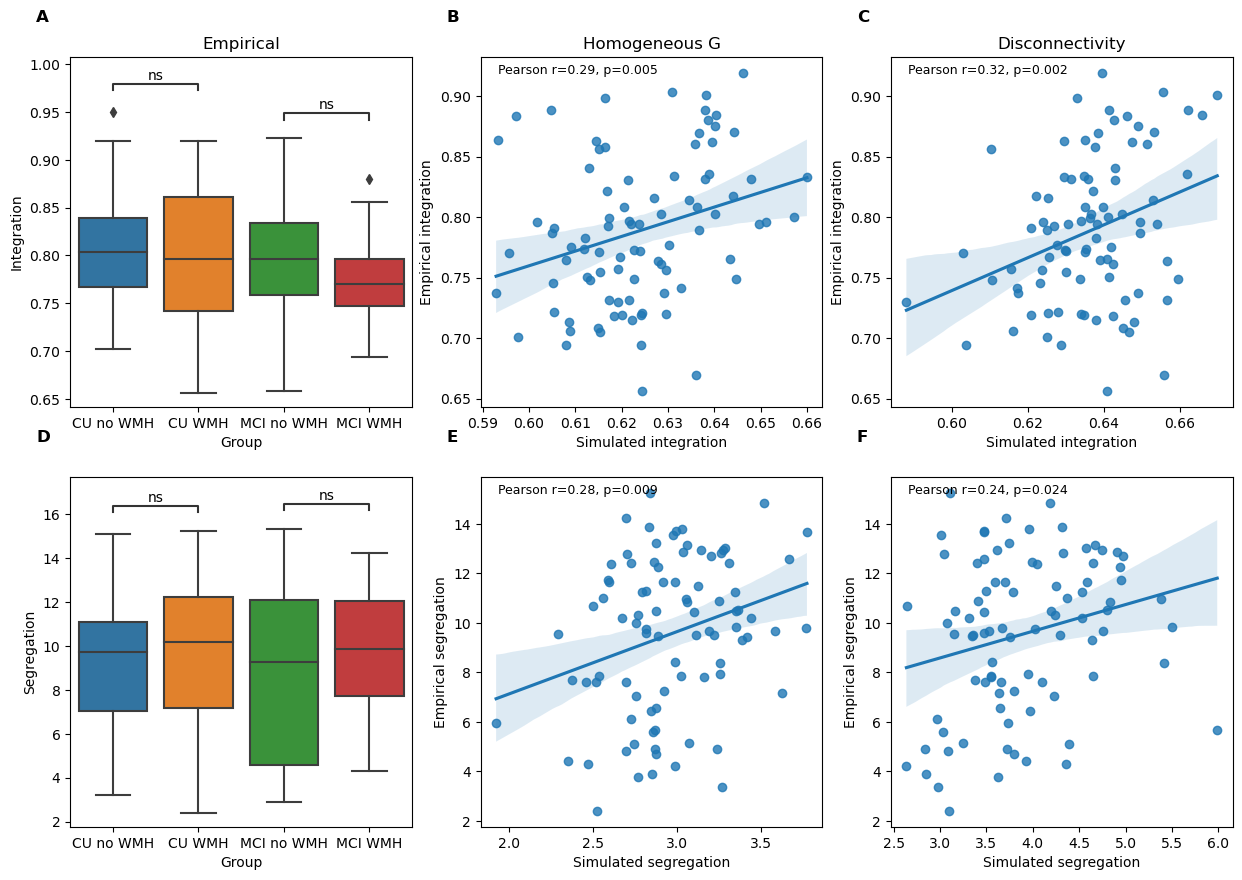

In [9]:
df_emp_int_seg = pd.merge(df_emp_int_seg, df_petTOAD[["PTID", "Group_bin_Fazekas"]])
fig, axs = plt.subplots(nrows=2, ncols = 3, figsize = (15, 10))
plot_int_or_seg_single_subject(df_emp_int_seg, "emp_int", axs[0, 0])
plot_int_or_seg_single_subject(df_emp_int_seg, "emp_seg", axs[1, 0])
regplot_with_corrcoef("All", df_int_seg_emp_sim_G, "sim_int", "emp_int", axs[0,1])
regplot_with_corrcoef("All", df_int_seg_emp_sim_G, "sim_seg", "emp_seg", axs[1,1])
regplot_with_corrcoef("All", df_int_seg_emp_sim_disconn, "sim_int", "emp_int", axs[0,2])
regplot_with_corrcoef("All", df_int_seg_emp_sim_disconn, "sim_seg", "emp_seg", axs[1,2])
axs[0,0].set_title("Empirical")
axs[0,1].set_title("Homogeneous G")
axs[0,2].set_title("Disconnectivity")
write_figure_letters(axs)